<a href="https://colab.research.google.com/github/ilhammmmsk/Tugas-Besar-Kecerdasan-Buatan/blob/main/cobacoba.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import calendar
import os
import re

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

print("✅ Library berhasil di-import!")

✅ Library berhasil di-import!


In [ ]:
import os
import pandas as pd

# Kita cari file yang ada angka ID "250934" biar pasti ketemu
daftar_file = [f for f in os.listdir() if '250934' in f and f.endswith('.xlsx')]

if len(daftar_file) > 0:
    file_path = daftar_file[0]

    # Baca Excel (skip 5 baris pertama)
    try:
        df_raw = pd.read_excel(file_path, sheet_name='Data', skiprows=5, header=None)
    except:
        df_raw = pd.read_excel(file_path, skiprows=5, header=None)

    # Ambil kolom Quarter & Subscribers
    df_raw = df_raw.iloc[:, [1, 2]]
    df_raw.columns = ['Quarter', 'Subscribers']
    df_raw = df_raw.dropna().reset_index(drop=True)

    print(f"✅ File DITEMUKAN: {file_path}")
    print("Jumlah Data Awal:", df_raw.shape)
    display(df_raw.head())

else:
    print("❌ Masih belum ketemu. Coba cek nama filenya lagi di folder sebelah kiri.")

✅ File DITEMUKAN: tatistic_id250934_quarterly-netflix-subscribers-count-worldwide-2013-2024 (1).xlsx.xlsx
Jumlah Data Awal: (48, 2)


,Quarter,Subscribers
0,Q1 2013,34.24
1,Q2 2013,35.64
2,Q3 2013,38.01
3,Q4 2013,41.43
4,Q1 2014,46.13


In [ ]:
# Fungsi mengubah "Q1 2013" -> Tanggal (Maret 2013)
def quarter_to_date(q_str):
    parts = q_str.split()
    q = int(parts[0][1])  # Ambil angka kuartal
    y = int(parts[1])     # Ambil tahun
    return pd.Timestamp(year=y, month=q*3, day=1) + pd.offsets.MonthEnd(1)

# Terapkan ke dataset
df = df_raw.copy()
df['Date'] = df['Quarter'].apply(quarter_to_date)
df = df.set_index('Date')
df = df.sort_index()

print("✅ Preprocessing selesai.")
print(f"📊 Menampilkan FULL {len(df)} Baris Data Mentah:")
print("-" * 40)

# --- INI KODE RAHASIANYA ---
pd.set_option('display.max_rows', None) # Paksa tampilkan semua baris
display(df)
pd.reset_option('display.max_rows') # Kembalikan ke settingan normal

✅ Preprocessing selesai.
📊 Menampilkan FULL 48 Baris Data Mentah:
----------------------------------------


,Quarter,Subscribers
Date,,
2013-03-31,Q1 2013,34.24
2013-06-30,Q2 2013,35.64
2013-09-30,Q3 2013,38.01
2013-12-31,Q4 2013,41.43
2014-03-31,Q1 2014,46.13
2014-06-30,Q2 2014,47.99
2014-09-30,Q3 2014,50.65
2014-12-31,Q4 2014,54.48
2015-03-31,Q1 2015,59.62


In [ ]:
# ===============================
# INTERPOLASI DATA KUARTAL -> BULAN
# ===============================

# Memastikan index adalah DatetimeIndex untuk resample
# Ini adalah safeguard jika df kehilangan DatetimeIndex karena inkonsistensi state notebook
if not isinstance(df.index, pd.DatetimeIndex):
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.set_index('Date')
    else:
        # Jika 'Date' tidak ada sebagai kolom dan index bukan DatetimeIndex, ada masalah lebih awal.
        # Ini seharusnya tidak terjadi jika alur preprocessing diikuti dengan benar.
        raise ValueError("DataFrame 'df' must have a 'Date' column or a DatetimeIndex.")

# Resample 'ME' (Month End) dan isi nilai kosong dengan garis lurus (linear)
# Menggunakan 'ME' sesuai FutureWarning
monthly_df = df.resample('ME').interpolate(method='linear')
monthly_df = monthly_df.reset_index() # Kembalikan Date jadi kolom biasa

# Tambahkan kolom numerik untuk AI
monthly_df['Month_Index'] = np.arange(len(monthly_df))

print("✅ Interpolasi selesai!")
print("Jumlah Data Sekarang:", monthly_df.shape) # Harusnya 144 baris

✅ Interpolasi selesai!
Jumlah Data Sekarang: (142, 4)


/tmp/ipython-input-2046023014.py:18: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  monthly_df = df.resample('ME').interpolate(method='linear')


In [ ]:
# --- UPDATE CELL 5: TAMPILKAN SEMUA DATA BULANAN ---

# Atur agar Pandas menampilkan SEMUA baris (max_rows = None)
pd.set_option('display.max_rows', None)

print(f"📊 Menampilkan FULL {len(monthly_df)} Baris Data Bulanan:")
print("-" * 40)

# Tampilkan DataFrame Bulanan
display(monthly_df)

# Kembalikan pengaturan ke default
pd.reset_option('display.max_rows')

📊 Menampilkan FULL 142 Baris Data Bulanan:
----------------------------------------


,Date,Quarter,Subscribers,Month_Index
0,2013-03-31,Q1 2013,34.240000,0
1,2013-04-30,NaN,34.706667,1
2,2013-05-31,NaN,35.173333,2
3,2013-06-30,Q2 2013,35.640000,3
4,2013-07-31,NaN,36.430000,4
5,2013-08-31,NaN,37.220000,5
6,2013-09-30,Q3 2013,38.010000,6
7,2013-10-31,NaN,39.150000,7
8,2013-11-30,NaN,40.290000,8
9,2013-12-31,Q4 2013,41.430000,9


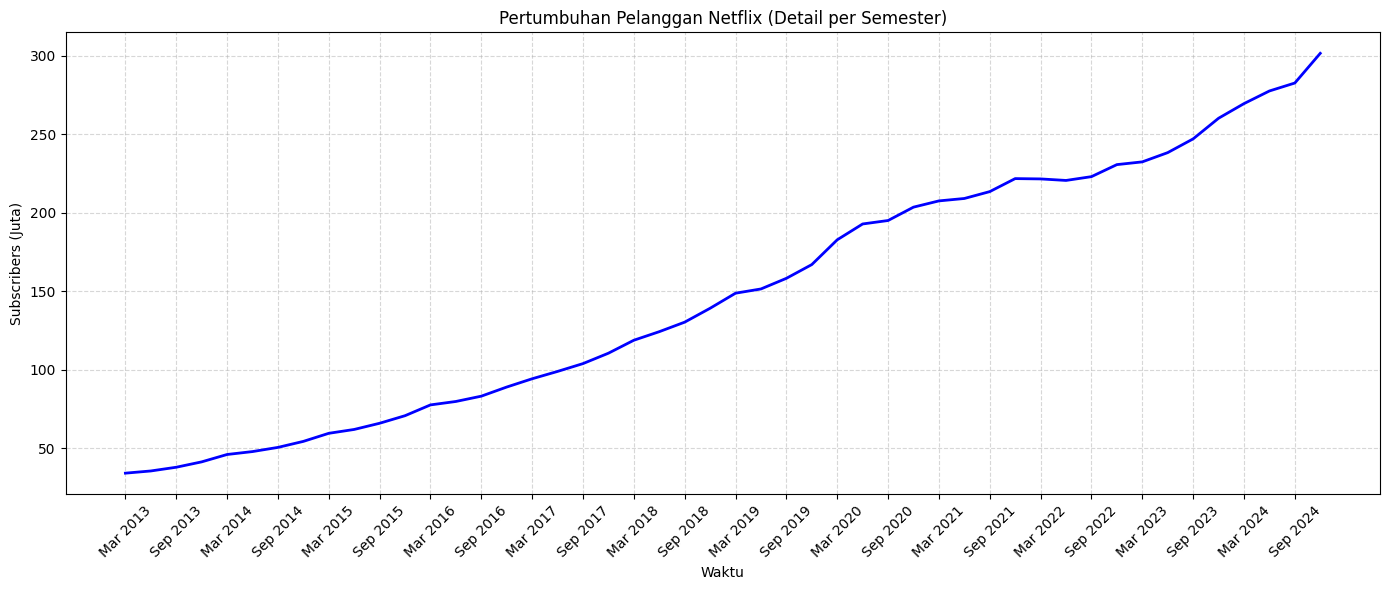

In [ ]:
# ===============================
# VISUALISASI DATA (2 BULAN PER TAHUN)
# ===============================

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6)) # Lebarkan sedikit biar label gak numpuk

# 1. Plot Garis
plt.plot(monthly_df['Month_Index'], monthly_df['Subscribers'], color='blue', linewidth=2)

# 2. Atur Label Sumbu X (Setiap 6 Bulan Sekali)
# [::6] artinya ambil data setiap kelipatan 6 bulan
ticks = monthly_df.iloc[::6]

# Format Label: "Bulan Tahun" (Contoh: Mar 2013, Sep 2013)
labels = ticks['Date'].dt.strftime('%b %Y')

# Pasang Label ke Grafik
plt.xticks(ticks['Month_Index'], labels, rotation=45)

# 3. Hiasan
plt.title("Pertumbuhan Pelanggan Netflix (Detail per Semester)")
plt.xlabel("Waktu")
plt.ylabel("Subscribers (Juta)")
plt.grid(True, linestyle='--', alpha=0.5)

# Biar tulisan miring tidak terpotong
plt.tight_layout()
plt.show()

In [ ]:
X = monthly_df[['Month_Index']]
y = monthly_df['Subscribers']

# Split data (shuffle=False karena ini data waktu/time series)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

print(f"Data Latih: {len(X_train)} bulan")
print(f"Data Uji  : {len(X_test)} bulan")

Data Latih: 113 bulan
Data Uji  : 29 bulan


In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)

# Prediksi untuk data uji
y_pred = model.predict(X_test)

print("✅ Model berhasil dilatih!")
print(f"Slope (m): {model.coef_[0]:.4f}")
print(f"Intercept (c): {model.intercept_:.4f}")

✅ Model berhasil dilatih!
Slope (m): 1.8967
Intercept (c): 14.3696


In [ ]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("=== HASIL EVALUASI ===")
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")

=== HASIL EVALUASI ===
MAE  : 7.2361
RMSE : 8.1240


In [ ]:
# Fungsi Konversi Tahun-Bulan ke Index
# Base date kita adalah Maret 2013 (Index 0)
def get_month_index(year, month):
    start_date = pd.Timestamp("2013-03-31")
    target_date = pd.Timestamp(year=year, month=month, day=28) + pd.offsets.MonthEnd(1)

    # Hitung selisih bulan
    diff = (target_date.year - start_date.year) * 12 + (target_date.month - start_date.month)
    return diff

print("--- PREDIKSI MANUAL ---")
try:
    input_year = int(input("Masukkan Tahun (misal 2025): "))
    input_month = int(input("Masukkan Bulan (1-12): "))

    idx = get_month_index(input_year, input_month)

    # Prediksi
    hasil = model.predict([[idx]])

    print(f"\n🔮 Prediksi Pelanggan Netflix pada {input_month}/{input_year}:")
    print(f"👉 {hasil[0]:.2f} juta, Subscribers")
except:
    print("Input salah, masukkan angka saja.")

--- PREDIKSI MANUAL ---
Masukkan Tahun (misal 2025): 2025
Masukkan Bulan (1-12): 3

🔮 Prediksi Pelanggan Netflix pada 3/2025:
👉 287.49 juta, Subscribers


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


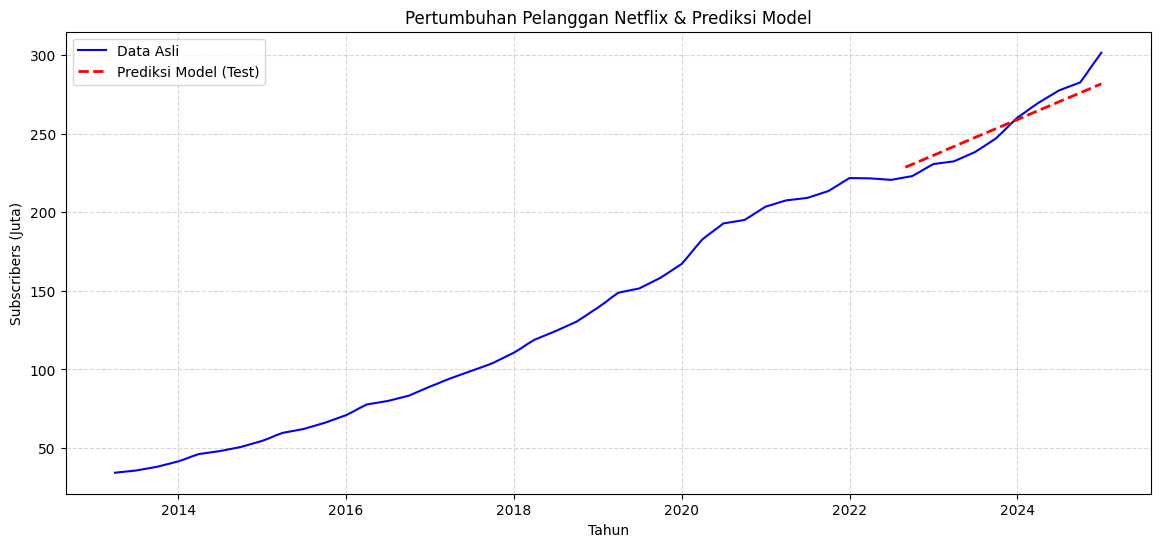

In [ ]:
# ===== Cell Visualisasi Akhir =====

plt.figure(figsize=(14, 6))

# Plot Data Asli
plt.plot(monthly_df['Date'], monthly_df['Subscribers'], label='Data Asli', color='blue')

# Plot Prediksi pada Data Uji
# Kita perlu tanggal untuk data uji
test_dates = monthly_df.iloc[X_test.index]['Date']
plt.plot(test_dates, y_pred, label='Prediksi Model (Test)', color='red', linestyle='--', linewidth=2)

plt.xlabel("Tahun")
plt.ylabel("Subscribers (Juta)")
plt.title("Pertumbuhan Pelanggan Netflix & Prediksi Model")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

# Tampilkan
plt.show()